In [1]:
from pathlib import Path
import nltk
import matplotlib.pyplot as plt
import numpy as np
from tanchuma_text import get_data
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from kraken.lib.dataset import preparse_xml_data
import pandas as pd

In [2]:
def compute_freq(txt, ngram = 1):
    #preprocess
    okay_letters = "אבגדהוזחטיכךלמםנןסעפףצץקרשת" + "\n" + " "
    txt_pp = txt.replace("ﭏ", "אל")
    txt_pp = "".join(x for x in txt_pp if x in okay_letters)
    txt_pp = txt_pp.replace("\n", " ")
    #remove double spaces
    txt_pp = txt_pp.replace("  ", " ")

    #Create your bigrams
    bgs = nltk.ngrams(txt_pp, ngram)

    #compute frequency counter for all the ngrams in the text
    fdist = nltk.FreqDist(bgs)

    # if single character level remove space
    # if ngram == 1:
    #     fdist.pop((' ',), None)

    #total number of ngrams
    total = float(sum(fdist.values()))
    #frequency of each ngram
    relfrq = [ x/total for x in fdist.values() ]
    relfreqs = dict(zip(fdist.keys(), relfrq))
    # for k,v in fdist.items():
    #     print(k,v)
    return relfreqs, fdist

# compute matrix of distances/similarity between rows of freqs_arr
def compute_metrics(freqs_arr):
    cosine_dists = freqs_arr.dot(freqs_arr.T)
    return cosine_dists

def plot_freqdists(freqdists, names):
    #sort by frequency
    all_tokens = [list(x.keys()) for x in freqdists]
    all_tokens = [item for sublist in all_tokens for item in sublist]   
    whole_alphabet = sorted(list(set(all_tokens)))
    freqs_arr = np.zeros((len(freqdists), len(whole_alphabet)))
    for i in range(len(freqdists)):
        for j in range(len(whole_alphabet)):
            freqs_arr[i,j] = freqdists[i].get(whole_alphabet[j], 0)
    
    #convert to percentages
    freqs_arr = 100*freqs_arr.T
    kmer = len(list(freqdists[0].keys())[0])
    if kmer == 1:
        #plot
        plt.figure(figsize=(20,10))
        lineObjects = plt.plot(freqs_arr)
        plt.legend(lineObjects, names)
        
        plt.title(f"{kmer}-mer frequencies")
        plt.xticks(range(len(whole_alphabet)), [x[0] for x in whole_alphabet], rotation=0)
        plt.ylabel("Frequency [%]")
        if kmer==1:
            plt.xlabel("Character")
        else:
            plt.xlabel(f"{kmer}-mer")
        plt.show()

        #test
        bar_width = 0.1
        plt.figure(figsize=(20,10))
        X_axis = np.arange(len(whole_alphabet)) - bar_width*1.5*(len(freqdists)/2-1)
        for y,name in zip(freqs_arr.T, names):
            plt.bar(X_axis, y, label=name, alpha=0.9, width = bar_width)
            X_axis = X_axis + bar_width*1.5

        plt.legend()
        # plt.title(f"{kmer}-mer frequencies")
        plt.xticks(range(len(whole_alphabet)), [x[0] for x in whole_alphabet], rotation=0)
        plt.ylabel("Frequency [%]")
        if kmer==1:
            plt.xlabel("Character")
        else:
            plt.xlabel(f"{kmer}-mer")
        plt.show()

    freqs_arr = freqs_arr.T

    #DEBUG
    #export to csv
    df = pd.DataFrame(freqs_arr, columns=[x[0] for x in whole_alphabet])

    cosine_similarities = cosine_similarity(freqs_arr)
    sns.heatmap(cosine_similarities, 
                xticklabels=names, 
                yticklabels=names, 
                annot=True, 
                fmt=".2f") #. #\
                #set_title(f"{kmer}-mer cosine similarities")

    return  freqs_arr#row is distribution, column is ngrams

Geneve 146:

In [3]:
geneve146_dir = '../data/Geneve146_v2'
geneve146_paths = [str(x)  for y in Path(geneve146_dir).glob('*') for x in y.glob('*.xml')]
g146_txts = preparse_xml_data(geneve146_paths, format_type='xml')
g146_txt = '\n'.join([x['text'] for x in g146_txts])

Region eSc_dummyblock_ without coordinates


Whole JA dataset:

In [4]:
ja_dir = Path("../data/judeo_arabic_data")
ja_files = ja_dir.glob("*.txt")
ja_txts = [f.read_text() for f in ja_files]
ja_txt = "\n".join(ja_txts)

Huntingtion ground truth and OCR by Hebrew model:

In [5]:
# huntington JA GT
df = pd.read_excel("../data/AraJda_11012023.xlsx", dtype={'control':str})
df['control'] = df['control'].fillna("")
gt_lst = df['control'].to_list()
gt_lst = [x for x in gt_lst if x != ""]
gt = " ".join(gt_lst)
gt = gt.replace("\u200f", "")
# gt = Path("../results/huntington115/huntington_115_gt.txt").read_text()

/home/vscode/.local/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [6]:
# huntington HTR by Hebrew model
ocr = Path("../results/huntington115/huntington_115_ocr.txt").read_text()

Tanchuma text:

In [7]:
tanchuma_train, tanchuma_test = get_data()
tanchuma_txt = "\n".join(tanchuma_train) + "\n" + "\n".join(tanchuma_test)

By character:

In [8]:
N = 1
to_display_1 = {}
#JA data
ja_fd, _ = compute_freq(ja_txt, ngram = N)
to_display_1["JA corpus"] = ja_fd

# huntington JA GT
gt_fd,_ = compute_freq(gt, ngram = N)
to_display_1["Huntington 115 GT"] = gt_fd

# huntington HTR by Hebrew model
ocr_fd,_ = compute_freq(ocr, ngram = N)
to_display_1["Huntington 115 HTR"] = ocr_fd

# Tanchuma
tanchuma_fd,_ = compute_freq(tanchuma_txt, ngram = N)
to_display_1["Tanchuma"] = tanchuma_fd

# Geneve 146
tanchuma_fd,_ = compute_freq(g146_txt, ngram = N)
to_display_1["Geneve 146"] = tanchuma_fd

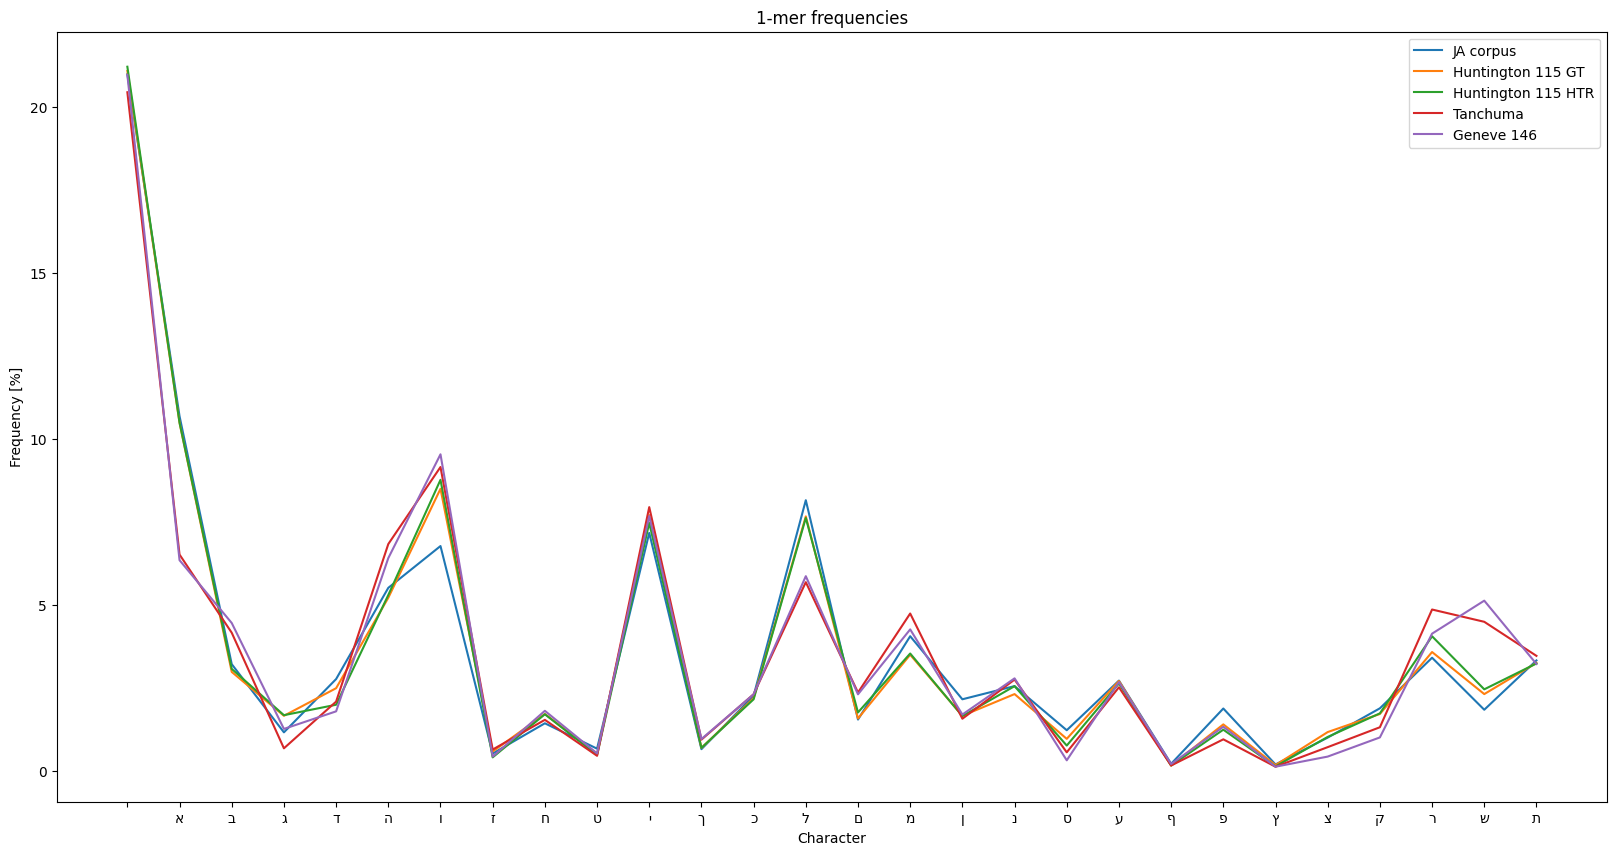

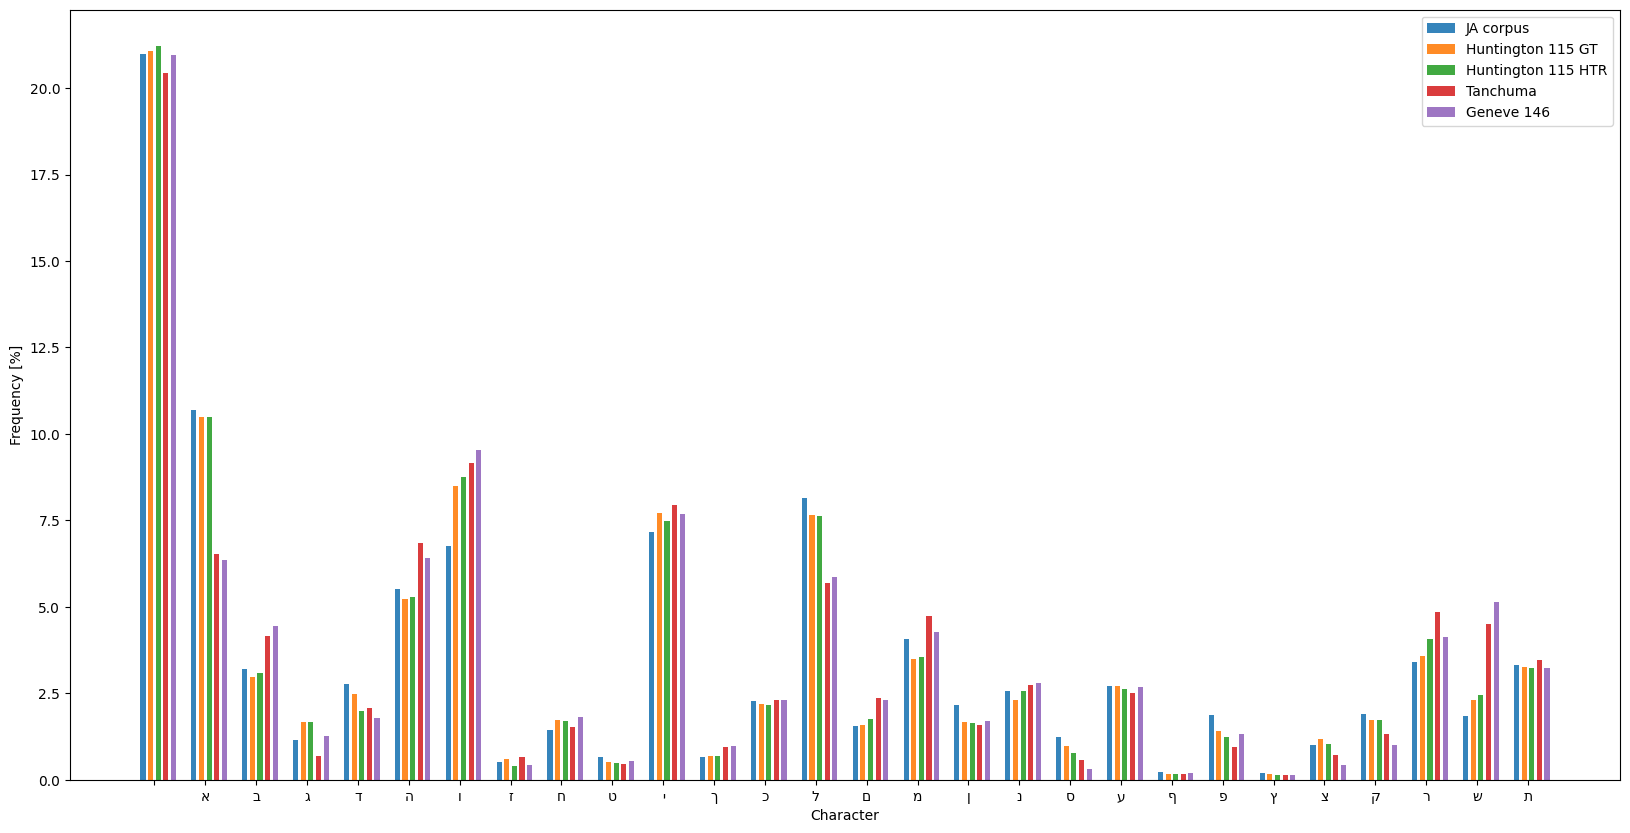

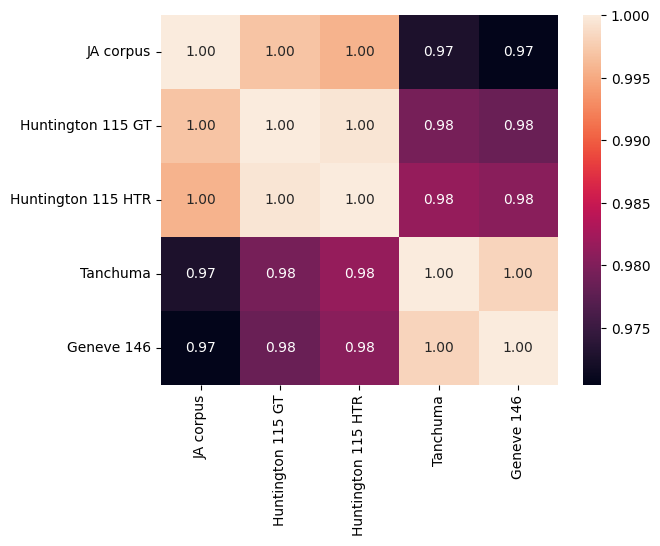

In [9]:
freqs_1_arr = plot_freqdists(list(to_display_1.values()), list(to_display_1.keys()))

array([[1.48940069, 4.2195368 , 1.19233903, ..., 0.14583811, 0.04014386,
        0.0403279 ],
       [0.        , 4.22170775, 1.1303282 , ..., 0.1089473 , 0.02723682,
        0.08171047],
       [0.01365747, 4.17918601, 1.21551489, ..., 0.12291724, 0.02731494,
        0.06828735],
       [0.        , 2.85555522, 1.59301193, ..., 0.07011294, 0.04319059,
        0.03610912],
       [0.06411284, 2.70876743, 1.73104664, ..., 0.01602821, 0.08014105,
        0.04808463]])

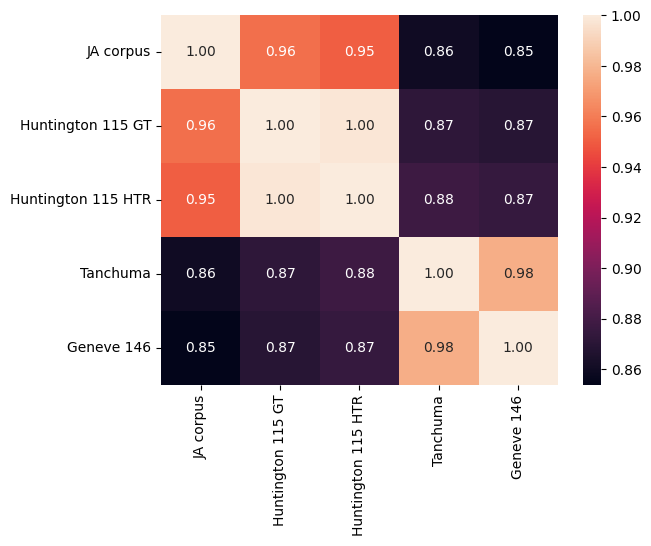

In [18]:
N = 2
to_display_2 = {}
#JA data
ja_fd, _ = compute_freq(ja_txt, ngram = N)
to_display_2["JA corpus"] = ja_fd

# huntington JA GT
gt_fd,_ = compute_freq(gt, ngram = N)
to_display_2["Huntington 115 GT"] = gt_fd


# huntington HTR by Hebrew model
ocr_fd,_ = compute_freq(ocr, ngram = N)
to_display_2["Huntington 115 HTR"] = ocr_fd

# Tanchuma
tanchuma_fd,_ = compute_freq(tanchuma_txt, ngram = N)
to_display_2["Tanchuma"] = tanchuma_fd

# Geneve 146
tanchuma_fd,_ = compute_freq(g146_txt, ngram = N)
to_display_2["Geneve 146"] = tanchuma_fd

plot_freqdists(list(to_display_2.values()), list(to_display_2.keys()))

In [11]:
#sort dict by value
tmp1 = {k: v for k, v in sorted(to_display_2["JA corpus"].items(), key=lambda item: item[1], reverse=True)}
print(str(tmp1)[:50])

{(' ', 'א'): 0.042195367953430214, ('א', 'ל'): 0.0


array([[0.00000000e+00, 1.82921186e-01, 3.77465640e-02, ...,
        1.60304243e-03, 4.01971364e-04, 5.81163418e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.82782323e-04, 0.00000000e+00, 3.18985270e-05],
       [3.20615582e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

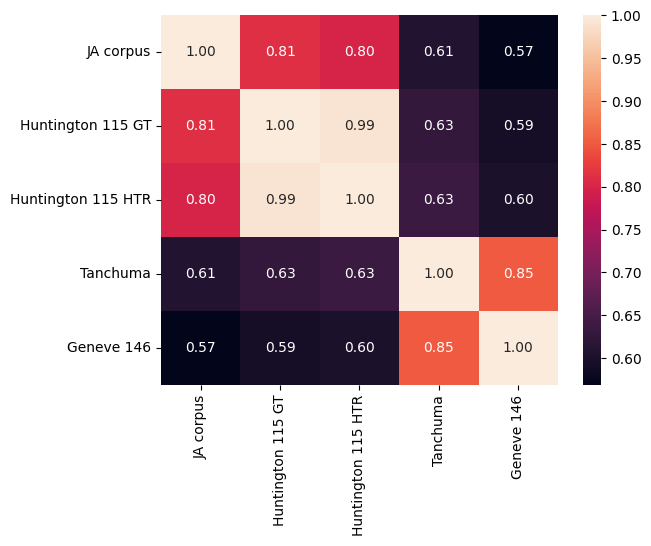

In [19]:
N = 3
to_display_3 = {}
#JA data
ja_fd, _ = compute_freq(ja_txt, ngram = N)
to_display_3["JA corpus"] = ja_fd

# huntington JA GT
gt_fd,_ = compute_freq(gt, ngram = N)
to_display_3["Huntington 115 GT"] = gt_fd


# huntington HTR by Hebrew model
ocr_fd,_ = compute_freq(ocr, ngram = N)
to_display_3["Huntington 115 HTR"] = ocr_fd

# Tanchuma
tanchuma_fd,_ = compute_freq(tanchuma_txt, ngram = N)
to_display_3["Tanchuma"] = tanchuma_fd

# Geneve 146
tanchuma_fd,_ = compute_freq(g146_txt, ngram = N)
to_display_3["Geneve 146"] = tanchuma_fd

plot_freqdists(list(to_display_3.values()), list(to_display_3.keys()))

In [13]:
100*to_display_3["JA corpus"][('א', 'ל', ' ')] , 100*to_display_3["Tanchuma"][('א', 'ל', ' ')]

(0.32644917820344665, 0.37522237260605545)

In [14]:
to_display_3["JA corpus"][('א', 'ל', ' ')] * to_display_3["Tanchuma"][('א', 'ל', ' ')]

1.2249103518079424e-05

array([[0.00000000e+00, 0.00000000e+00, 5.61791332e-04, ...,
        4.84302872e-06, 4.84302872e-06, 4.84302872e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.60333494e-02, 1.60333494e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

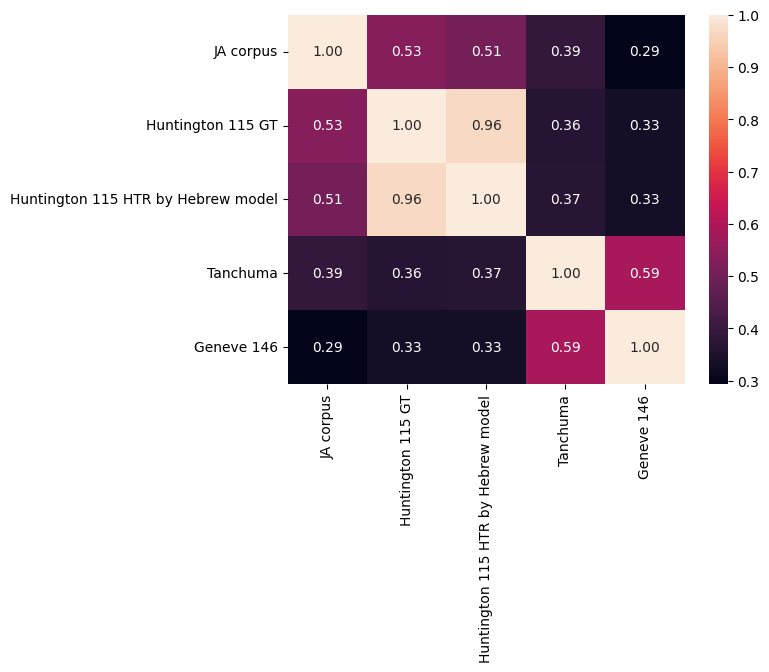

In [15]:
N = 4
to_display_4 = {}
#JA data
ja_fd, _ = compute_freq(ja_txt, ngram = N)
to_display_4["JA corpus"] = ja_fd

# huntington JA GT
gt_fd,_ = compute_freq(gt, ngram = N)
to_display_4["Huntington 115 GT"] = gt_fd


# huntington HTR by Hebrew model
ocr_fd,_ = compute_freq(ocr, ngram = N)
to_display_4["Huntington 115 HTR by Hebrew model"] = ocr_fd

# Tanchuma
tanchuma_fd,_ = compute_freq(tanchuma_txt, ngram = N)
to_display_4["Tanchuma"] = tanchuma_fd

# Geneve 146
tanchuma_fd,_ = compute_freq(g146_txt, ngram = N)
to_display_4["Geneve 146"] = tanchuma_fd

plot_freqdists(list(to_display_4.values()), list(to_display_4.keys()))

In [16]:
100*to_display_4["JA corpus"][(' ','א', 'ל', ' ')] , 100*to_display_4["Tanchuma"][(' ','א', 'ל', ' ')]

(0.045921598338957384, 0.14226747561356837)

In [17]:
100*to_display_4["Huntington 115 GT"][(' ','א', 'ל', ' ')] , 100*to_display_4["Geneve 146"][(' ','א', 'ל', ' ')], 100*to_display_4["Huntington 115 HTR by Hebrew model"][(' ','א', 'ל', ' ')]

(1.3622122326658495, 0.2084335417668751, 1.407103825136612)